<a href="https://colab.research.google.com/github/adphelps/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 132
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=22.273646023922907, pvalue=1.4565963588062096e-05)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## T-test Assumptions

In [0]:
from scipy.stats import ttest_ind

?ttest_ind

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

- Independence of means

Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).

- "Homogeneity" of Variance? 

Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test

- "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test. This problem typically goes away for large sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up. People declare the assumption to be satisfied either way. 



## Central Limit Theorem



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

N = 3000
sample_means = []
for x in range(0,N):
  coinflips = np.random.binomial(n=1, p=.5, size=100)
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means)

3000
[0.59, 0.51, 0.47, 0.44, 0.51, 0.52, 0.49, 0.54, 0.47, 0.49, 0.5, 0.5, 0.5, 0.54, 0.46, 0.45, 0.48, 0.58, 0.54, 0.52, 0.54, 0.47, 0.35, 0.5, 0.59, 0.48, 0.51, 0.47, 0.53, 0.44, 0.51, 0.5, 0.48, 0.46, 0.47, 0.48, 0.55, 0.51, 0.48, 0.52, 0.48, 0.58, 0.55, 0.43, 0.5, 0.4, 0.45, 0.56, 0.52, 0.49, 0.56, 0.42, 0.46, 0.5, 0.5, 0.51, 0.58, 0.44, 0.49, 0.46, 0.56, 0.51, 0.47, 0.59, 0.44, 0.54, 0.58, 0.47, 0.48, 0.53, 0.49, 0.49, 0.46, 0.45, 0.5, 0.47, 0.51, 0.58, 0.51, 0.5, 0.52, 0.49, 0.5, 0.5, 0.45, 0.44, 0.55, 0.55, 0.54, 0.53, 0.52, 0.5, 0.5, 0.5, 0.49, 0.47, 0.56, 0.52, 0.53, 0.55, 0.48, 0.5, 0.61, 0.47, 0.52, 0.51, 0.52, 0.5, 0.5, 0.48, 0.43, 0.52, 0.43, 0.54, 0.49, 0.56, 0.48, 0.5, 0.49, 0.46, 0.55, 0.56, 0.53, 0.52, 0.58, 0.48, 0.47, 0.51, 0.49, 0.53, 0.56, 0.49, 0.43, 0.51, 0.45, 0.46, 0.44, 0.51, 0.5, 0.55, 0.45, 0.47, 0.51, 0.5, 0.57, 0.51, 0.51, 0.5, 0.51, 0.48, 0.42, 0.4, 0.47, 0.45, 0.52, 0.54, 0.53, 0.44, 0.47, 0.5, 0.55, 0.54, 0.52, 0.5, 0.5, 0.54, 0.42, 0.51, 0.53, 0.55, 0

In [0]:
# Create dataframe with single coin flip
df = pd.DataFrame({'one-samp': one_sample})
df.head()

,one-samp
0,1
1,0
2,0
3,0
4,0


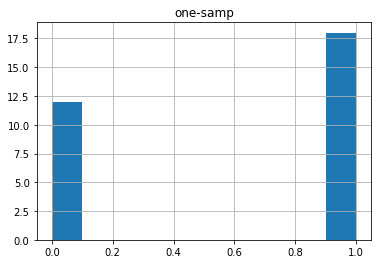

In [0]:
# Plot histogram to look at distribution of a single coin flip 
df.hist();

Text(0.5, 1.0, 'Distribution of 3000 sample means \n (of 30 coinflips each)')

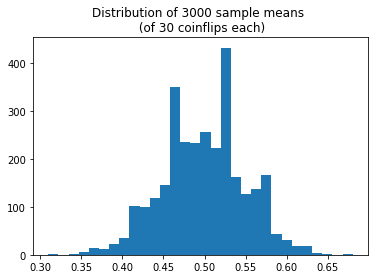

In [0]:
# Plot histogram to look at distribution of all coin flips
ax = plt.hist(sample_means, bins=30)
plt.title(f'Distribution of {N} sample means \n (of 30 coinflips each)')

What does the Central Limit Theorem State? That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

In [0]:
import numpy as np
import pandas as pd

# Average Height
mu = 70
sigma = 3

lambda_heights = np.random.normal(mu, sigma, 2000)
print(len(lambda_heights))
lambda_heights

2000


array([60.80764089, 73.5039455 , 70.21228116, ..., 73.82185087,
       68.33573581, 67.32813212])

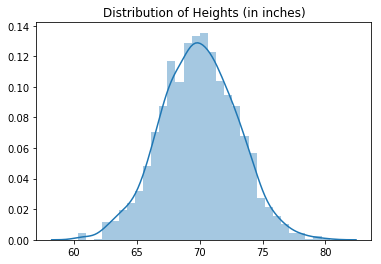

In [0]:
import seaborn as sns

sns.distplot(lambda_heights)
plt.title('Distribution of Heights (in inches)');

In [0]:
print("Population Mean:", lambda_heights.mean())
print("Population Standard Deviation:", lambda_heights.std())

Population Mean: 69.9244074931925
Population Standard Deviation: 3.013375198153731


In [0]:
population = pd.DataFrame({'heights': lambda_heights})
print(population.shape)
population.head()

(2000, 1)


,heights
0,60.807641
1,73.503945
2,70.212281
3,69.347116
4,65.832260


In [0]:
# Take a random sample and print sample mean
sample1 = population.sample(100)
print(sample1.shape)
print(sample1.head())
print('Sample Mean #1:', sample1['heights'].mean())

(100, 1)
        heights
1256  64.495121
401   71.177529
1285  67.506551
137   70.576109
390   71.019588
Sample Mean #1: 69.93525089781411


In [0]:
# Take a different random sample and print sample mean
sample2 = population.sample(100)
print(sample2.shape)
sample2.head()
print('Sample Mean #2:', sample2['heights'].mean())

(100, 1)
Sample Mean #2: 70.15256588520685


## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

In [0]:
coinflips_100 = np.random.binomial(n=1, p=0.5, size=100)

sample_std = np.std(coinflips_100)
print('sample St Dev:', sample_std)
sample_size = len(coinflips_100)
print('Sample Size:', sample_size)

sample St Dev: 0.4963869458396343
Sample Size: 100


In [0]:
standard_error = sample_std/np.sqrt(sample_size)
print(standard_error)

0.04963869458396343


### What confidence level do we want our confidence interval to represent?

95% confidence Interval? 99% confidence interval? 

In [0]:
import scipy.stats as stats

t = stats.t.ppf(0.975, sample_size-1)
t

1.9842169515086827

In [0]:
sample_mean = coinflips_100.mean()
confidence_interval = (sample_mean - t*standard_error, sample_mean + t*standard_error)
margin_of_error = t*standard_error

print('Sample Mean:', sample_mean)
print('Margin of Error:', margin_of_error)
print('Confidence Interval:', confidence_interval)

Sample Mean: 0.56
Margin of Error: 0.09849393924426247
Confidence Interval: (0.4615060607557376, 0.6584939392442626)


## Graphically Represent a Confidence Interval

## Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

In [0]:
from scipy.stats import t, ttest_1samp

In [0]:
import numpy as np

coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means)

[0.43333333333333335, 0.4666666666666667, 0.6333333333333333, 0.5666666666666667, 0.4666666666666667, 0.43333333333333335, 0.4666666666666667, 0.6, 0.5, 0.5333333333333333, 0.6, 0.7, 0.4666666666666667, 0.5, 0.5, 0.5333333333333333, 0.5, 0.5333333333333333, 0.6333333333333333, 0.43333333333333335, 0.5, 0.6, 0.5333333333333333, 0.5666666666666667, 0.4, 0.6, 0.5, 0.5666666666666667, 0.4666666666666667, 0.5333333333333333, 0.6333333333333333, 0.4, 0.3333333333333333, 0.4666666666666667, 0.43333333333333335, 0.6, 0.5333333333333333, 0.5666666666666667, 0.43333333333333335, 0.5333333333333333, 0.5666666666666667, 0.6333333333333333, 0.5, 0.6, 0.43333333333333335, 0.36666666666666664, 0.5333333333333333, 0.5666666666666667, 0.3333333333333333, 0.5666666666666667, 0.5333333333333333, 0.6, 0.43333333333333335, 0.6333333333333333, 0.6, 0.6333333333333333, 0.5666666666666667, 0.4666666666666667, 0.4666666666666667, 0.5333333333333333, 0.7, 0.4, 0.5333333333333333, 0.4666666666666667, 0.566666666

In [0]:
# 95% confidence interval

t_stat = stats.t.ppf(0.975, 99)
print('T Statistic:', t_stat)

std_sample = np.std(coinflip_means)
std_err = std_sample/np.sqrt(len(coinflip_means))

ci = stats.t.interval(0.95, 99, loc=np.mean(coinflip_means), scale=std_err)
print('95% confidence interval:', ci)

T Statistic: 1.9842169515086827
95% confidence interval: (0.48959371824391434, 0.5244062817560855)


A null hypothesis that's just inside of our confidence interval == fail to reject



In [0]:
ttest_1samp(coinflip_means, 0.48959)

Ttest_1sampResult(statistic=2.851451683256232, pvalue=0.005297395090012808)

A null hypothesis that's just outside of our confidence interval == reject



In [0]:
ttest_1samp(coinflip_means, 0.52441)

Ttest_1sampResult(statistic=-1.974692673249469, pvalue=0.0510884837773506)

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
df.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


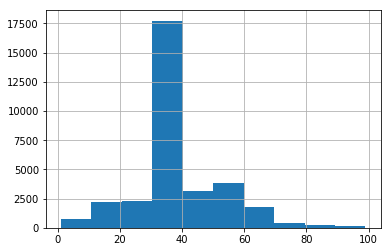

In [0]:
df['hours-per-week'].hist();

In [0]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [0]:
cut_points = [0, 9, 19, 29, 39, 49, 500]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)
df.hours_per_week_categories.value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [0]:
df.sex.value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [0]:
df = df.sort_values(by='hours_per_week_categories')
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


## Expected Value Calculation
\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}

In [0]:
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values
print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [0]:
total = contingency_table.loc['All', 'All']
total

32561

In [0]:
expected =[]
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
expected = np.array(expected)
print(expected.shape)
print(expected)

(2, 6)
[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


## Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [0]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
print(observed.shape)
observed

(2, 6)


array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [0]:
chi_square = ((observed - expected)**2/(expected)).sum()
chi_square

2287.190943926107

## Run a $\chi^{2}$ Test using Scipy

In [0]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
print(chi_squared, p_value, dof, expected)

2287.190943926107 0.0 5 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


Null Hypothesis: Hours worked per week bins is **independent** of sex. 

Due to a p-value of 0, we REJECT the null hypothesis that hours worked per week and sex are independent, and conclude that there is an association between hours worked per week and sex. 

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
# TODO - your code!

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)